From week 3, we have true theta (params for h) and true z prime, as well as esitmated thetas and z primes. Now we want to visualize success. Let's see how good these z primes are, compared to the true z primes, and see if we can plot the marginal posteriors for z primes. This will show us the confidence in each inter-beat interval.

In [6]:
import numpy as np
from numpyro import sample, plate
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax
import jax.random as random
import seaborn as sns


In [2]:
# GENERATE SYNTHETIC DATA

# generate 10 heartbeats, interval 1.0s
num_beats = 10
true_z_prime = np.ones(num_beats)  # 1 beat every 1s for 20s
spike_times = np.cumsum(true_z_prime)  # get actual times for each beat

# ground truth h kernel params (amp and width)
true_amp = 1
true_width = .1

# time domain (steps from 0s - 20s)
t = np.linspace(0, 10, 1000)

# gaussian kernel function h(theta)
# loop thru all times when beats occur and for each spike, add gaussian bump to signal time.
# then, sum all contributions to get combined effect
def heartbeat_kernel(t, spike_times, amp, width):
    signal = np.zeros_like(t)
    for s in spike_times:
        signal += amp * np.exp(-0.5 * ((t - s) / width) ** 2)
    return signal

# Observed signal y(t) = x * h(theta) + noise
x = np.ones_like(t)  # ECG signal is constant (for simplicity)
y_obs = heartbeat_kernel(t, spike_times, true_amp, true_width) + np.random.normal(0, 0.05, size=t.shape)


In [3]:
# DEFINE MODEL

# sample z', convert to spike times, create signal by adding pulses shaped by theta (amp, width)
# GOAL: infer params of h
def model(t, x, y_obs, num_beats):
    # prior for h parameters (theta), both must be non negative
    amp = sample("amp", dist.HalfNormal(1.0))
    width = sample("width", dist.HalfNormal(0.3))
    
    # prior over z_prime (between-beat intervals)
    # sample independent between-beat intervals z'
    with plate("beats", num_beats):
        z_prime = sample("z_prime", dist.TruncatedNormal(0.8, 0.3, low=0.5))  # truncated norm to make sure no between beat gets below 0.5s
    
    # cumulative sum of z_prime to get spike times
    # gives us heartbeat times at which each beat kernel will be centered
    spike_times = jnp.cumsum(z_prime)

    # generate heartbeat signal h_theta(t) using the kernel
    def h_single(s):
        return amp * jnp.exp(-0.5 * ((t - s) / width) ** 2)

    # loop over spike times, generate pulse for each one
    # creates 2d array, 1 row per pulse
    # sum makes it into 1 waveform to model a single heartbeat signal
    # predicted signal, commpare to real signal later
    y_hat = jnp.sum(jnp.stack([h_single(s) for s in spike_times]), axis=0)

    # Likelihood: Gaussian noise around true y_obs
    sigma_noise = 0.05  # fixed noise level
    sample("obs", dist.Normal(y_hat, sigma_noise), obs=y_obs)

In [4]:
# MCMC

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=1000)
mcmc.run(random.PRNGKey(0), t=jnp.array(t), x=jnp.array(x), y_obs=jnp.array(y_obs), num_beats=num_beats)
posterior_samples = mcmc.get_samples()

mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [00:15<00:00, 99.81it/s, 31 steps of size 8.29e-02. acc. prob=0.94] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       amp      1.00      0.01      1.00      0.99      1.01    882.57      1.00
     width      0.10      0.00      0.10      0.10      0.10    838.34      1.00
z_prime[0]      1.00      0.00      1.00      1.00      1.00    998.73      1.00
z_prime[1]      1.00      0.00      1.00      1.00      1.01    738.98      1.00
z_prime[2]      1.00      0.00      1.00      1.00      1.00    551.83      1.00
z_prime[3]      1.00      0.00      1.00      1.00      1.01    654.60      1.00
z_prime[4]      1.00      0.00      1.00      0.99      1.00    788.41      1.00
z_prime[5]      1.00      0.00      1.00      1.00      1.01    988.82      1.00
z_prime[6]      2.00      0.00      2.00      1.99      2.00   1318.90      1.00
z_prime[7]      1.00      0.00      1.00      1.00      1.01    870.88      1.00
z_prime[8]      1.00      0.00      1.00      0.99      1.00    707.65      1.00
z_prime[9]      0.89      0

In [5]:
# COMPARE INFERENCE RESULTS

# compare mean estimates vs true values
z_est = np.mean(posterior_samples["z_prime"], axis=0)
amp_est = np.mean(posterior_samples["amp"])
width_est = np.mean(posterior_samples["width"])

print("true vs estimated:")
print(f"amp:   true={true_amp:.3f},  estimated={amp_est:.3f}")
print(f"width: true={true_width:.3f}, estimated={width_est:.3f}")
print(f"z′[0:5]:\n  true={true_z_prime[:10]}\n  est.={z_est[:10]}")

true vs estimated:
amp:   true=1.000,  estimated=0.997
width: true=0.100, estimated=0.101
z′[0:5]:
  true=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  est.=[0.99889547 1.001284   1.0001712  1.0035706  0.9950201  1.0031401
 1.996645   1.0023102  0.9991803  0.892331  ]


PLOTTING BELOW

Marginals show uncertainty and bias, so they can help us determine if we're on the right track for our z' and theta parameters

Joints can show correlation between parameters to give us more insight into our model and variables

By comparing predicted values to true values, we'll be able to visually see how well we're doing


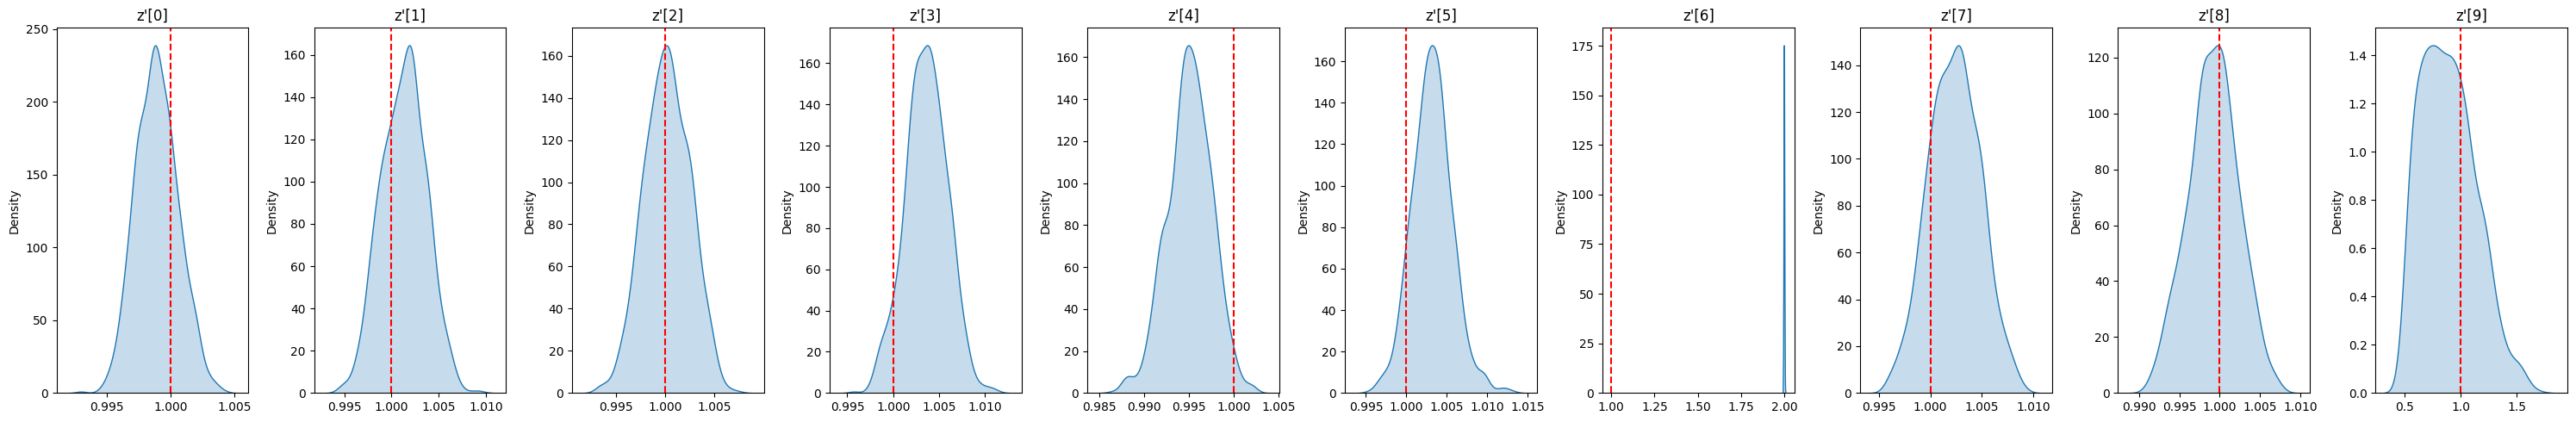

In [18]:
# PLOT: z' marginals
# shows how confident our model is about each inter-beat interval

num_beats = posterior_samples['z_prime'].shape[1]

fig, axes = plt.subplots(1, 10, figsize=(30, 5))  # Plot first 5 z' for example
for i in range(10):
    sns.kdeplot(posterior_samples['z_prime'][:, i], ax=axes[i], fill=True)
    axes[i].axvline(true_z_prime[i], color='r', linestyle='--')
    axes[i].set_title(f"z'[{i}]")

plt.tight_layout()
plt.show()

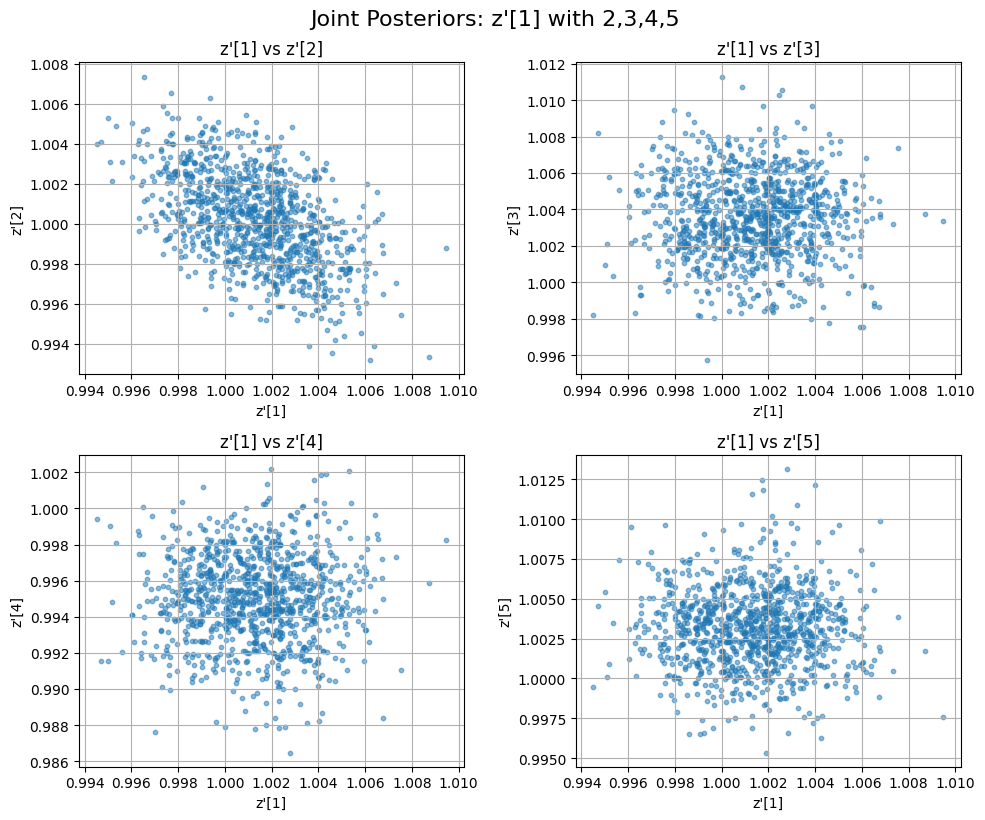

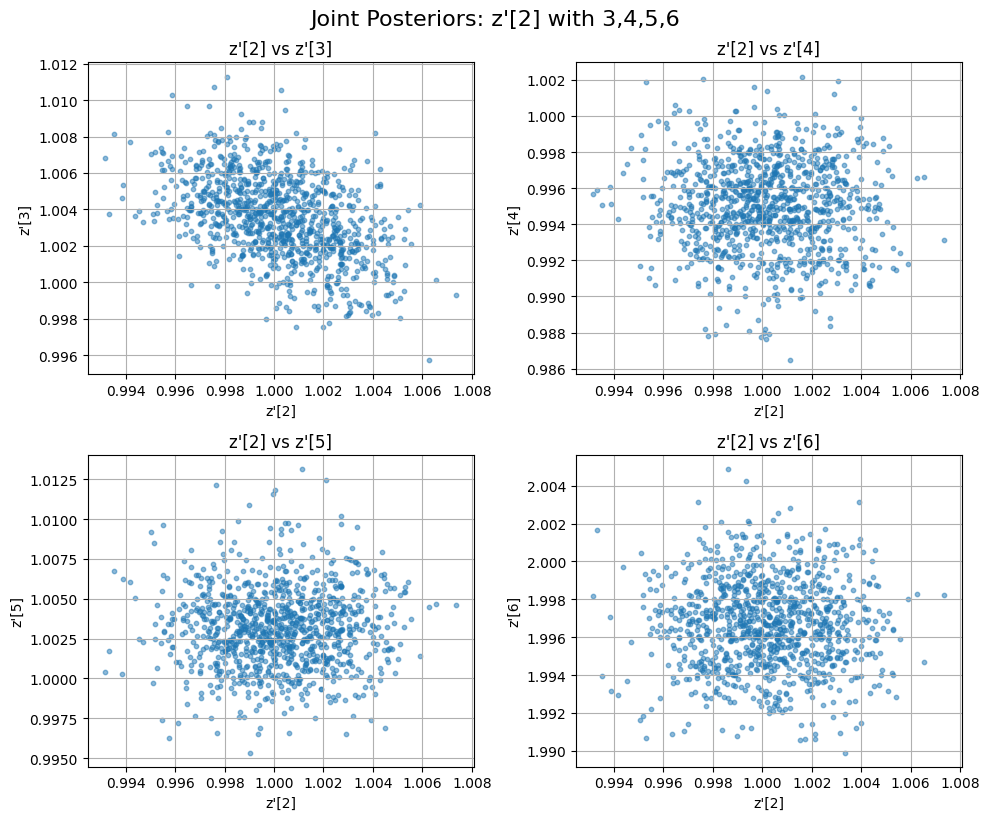

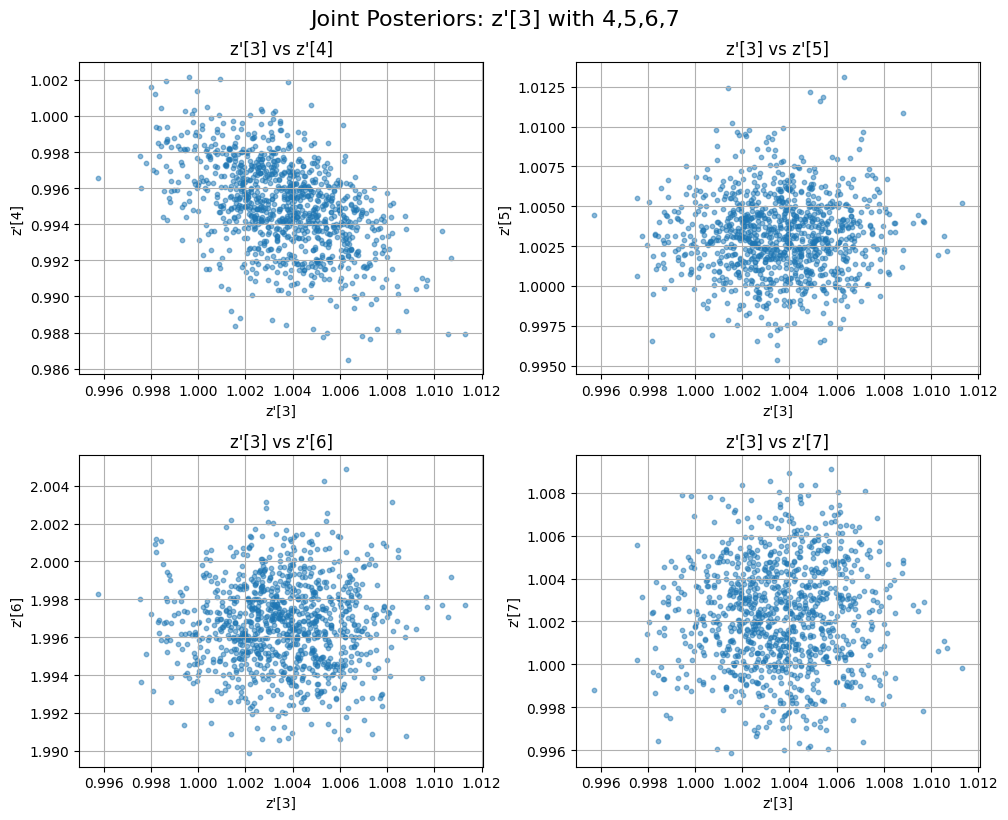

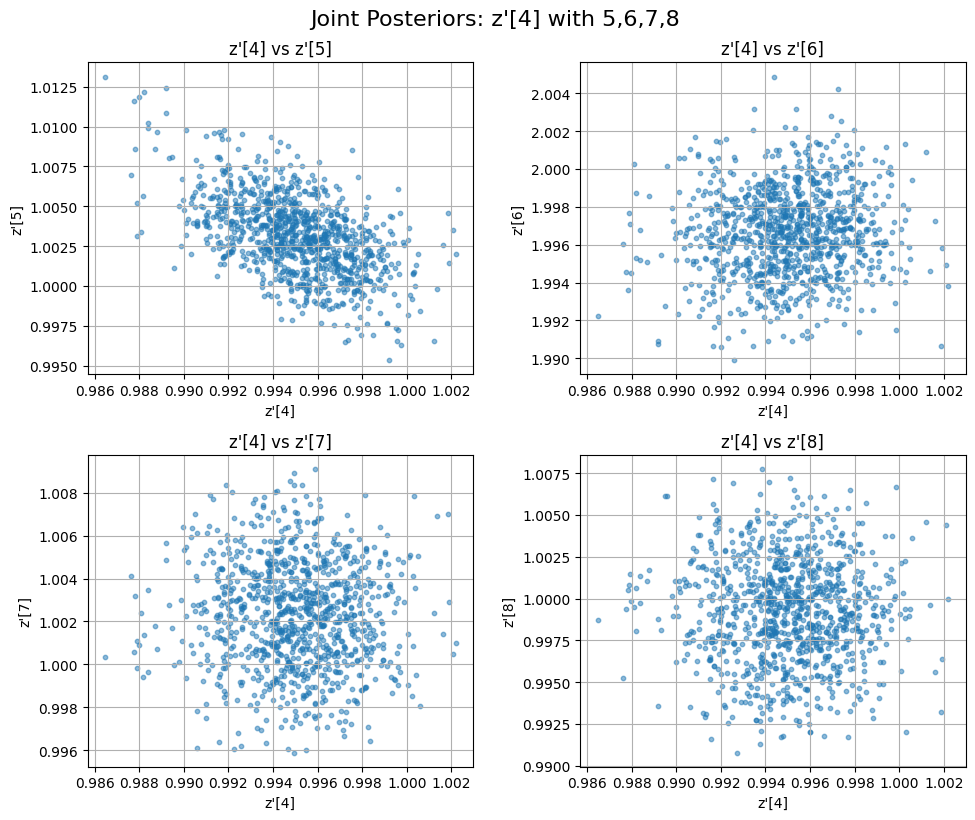

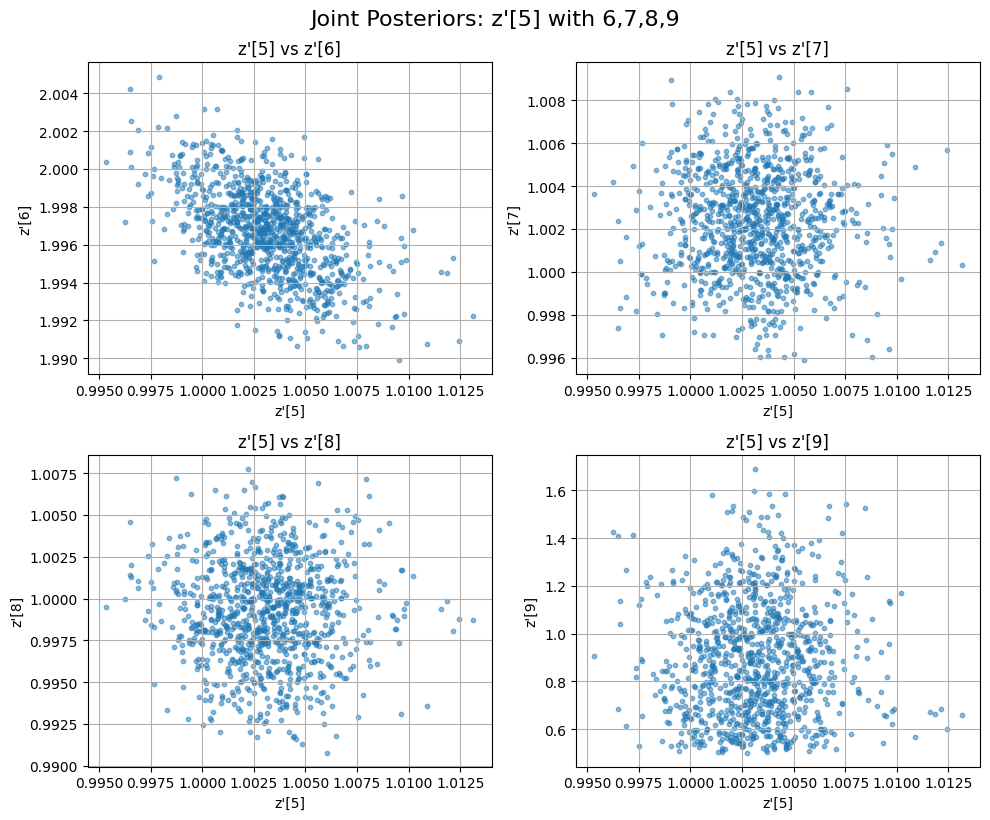

In [24]:
# PLOT: joint posterior between multiple z'
# this checks if there are correlations between the inter-beat intervals

# EXPLANATION OF RESULTS:
# if one z' gets longer, the next one needs to be shorter, so that roughly explains
# inverse relationship between z[x]' and z[x + 1]'

z_prime_samples = posterior_samples['z_prime']  # shape (num_samples, num_beats)

# plot 4 pairs at a time
def plot_pairs(pairs, batch_title):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs = axs.flat
    for idx, (i, j) in enumerate(pairs):
        if idx < len(pairs):
            ax = axs[idx]
            ax.scatter(z_prime_samples[:, i], z_prime_samples[:, j], alpha=0.5, s=10)
            ax.set_xlabel(f"z'[{i}]")
            ax.set_ylabel(f"z'[{j}]")
            ax.set_title(f"z'[{i}] vs z'[{j}]")
            ax.grid(True)
        else:
            axs[idx].axis('off')  # hide empty plots if < 4 pairs
    plt.tight_layout()
    plt.suptitle(batch_title, fontsize=16, y=1.02)
    plt.show()

# pairs to plot
all_pairs = [
    [(1, 2), (1, 3), (1, 4), (1, 5)],
    [(2, 3), (2, 4), (2, 5), (2, 6)],
    [(3, 4), (3, 5), (3, 6), (3, 7)],
    [(4, 5), (4, 6), (4, 7), (4, 8)],
    [(5, 6), (5, 7), (5, 8), (5, 9)]
]

# Plot each batch
titles = [
    "Joint Posteriors: z'[1] with 2,3,4,5",
    "Joint Posteriors: z'[2] with 3,4,5,6",
    "Joint Posteriors: z'[3] with 4,5,6,7",
    "Joint Posteriors: z'[4] with 5,6,7,8", 
    "Joint Posteriors: z'[5] with 6,7,8,9"
]

for pairs, title in zip(all_pairs, titles):
    plot_pairs(pairs, title)

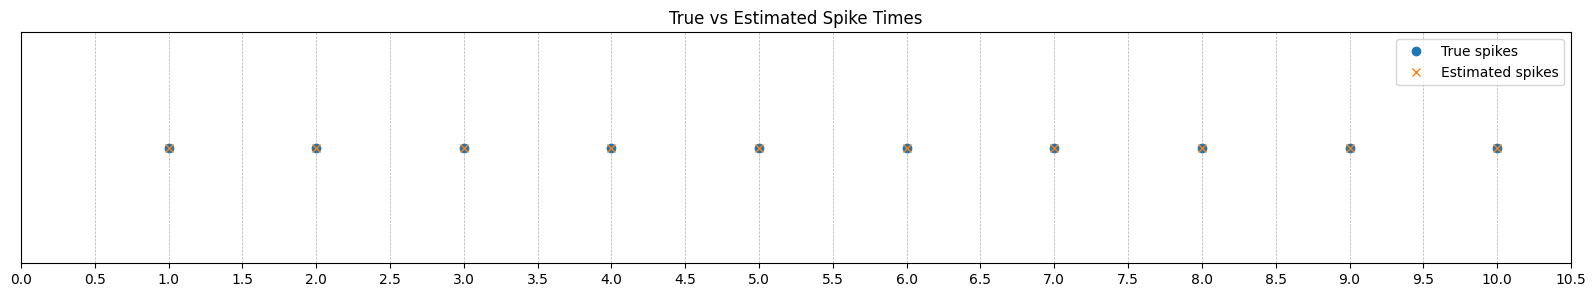

In [33]:
# PLOT: convert all z' (inter beat intervals) to z (actual beat time) and 
# see how those estimated z compared to the real z

z_prime_spike_times = np.cumsum(true_z_prime)

# Plot true vs estimated spike times
plt.figure(figsize=(20, 3))
plt.plot(spike_times, np.zeros_like(spike_times), 'o', label="True spikes")
plt.plot(z_prime_spike_times, np.zeros_like(z_prime_spike_times), 'x', label="Estimated spikes")

plt.yticks([])
plt.legend()
plt.title("True vs Estimated Spike Times")
# Fine-grained x-ticks
plt.xticks(np.arange(0, np.max(spike_times) + 1, 0.5))  # tick every 0.5 seconds

# Optional: finer gridlines for clarity
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

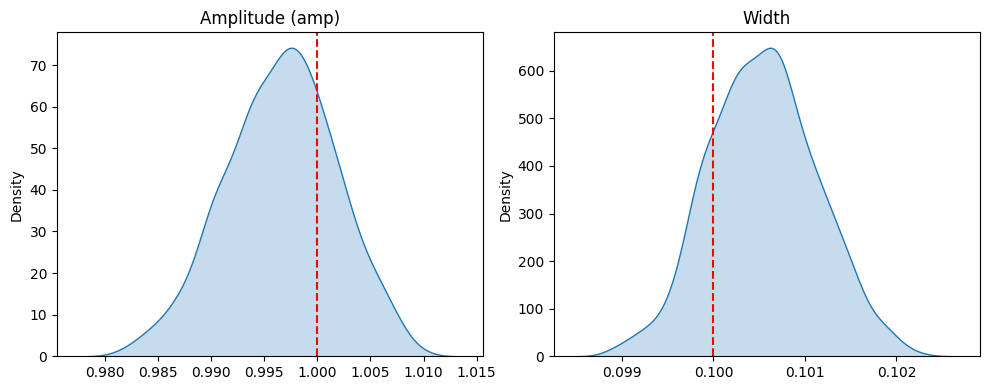

In [34]:
# PLOT: posterior marginals for amp and width (thetas)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.kdeplot(posterior_samples['amp'], ax=axes[0], fill=True)
axes[0].axvline(true_amp, color='r', linestyle='--')
axes[0].set_title("Amplitude (amp)")

sns.kdeplot(posterior_samples['width'], ax=axes[1], fill=True)
axes[1].axvline(true_width, color='r', linestyle='--')
axes[1].set_title("Width")

plt.tight_layout()
plt.show()

PRIORS:

Priors are the belief before we actually give the model any data.

- if too broad --> model will explore too many crazy values that wouldn't make sense sometimes in real situations, introduce uncertainty and noise

- if too narrow (while not containig true value) --> model can never recover and will be biased towards the wrong values

Thus, finding the narrowest, accurate priors can help our model bc we can tell it roughly where the answer/true value(s) should be.
